In [1]:
import sys
sys.path.insert(0, '.')

In [2]:
# !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

In [3]:
# import bz2
# fromF = bz2.open("shape_predictor_68_face_landmarks.dat.bz2", "rb")
# data = fromF.read()
# toF = open("shape_predictor_68_face_landmarks.dat", "wb")
# toF.write(data)

In [4]:
from imutils import face_utils
from scipy.spatial import Delaunay
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pyface import Face, put_face_on_image, combine_faces, face_morphing, drawCoords, drawLines

In [5]:
depp_image = np.array(Image.open('images/depp.jpg'))
kanye_image = np.array(Image.open('images/kanye.jpg'))
depp = Face(depp_image)
kanye = Face(kanye_image)

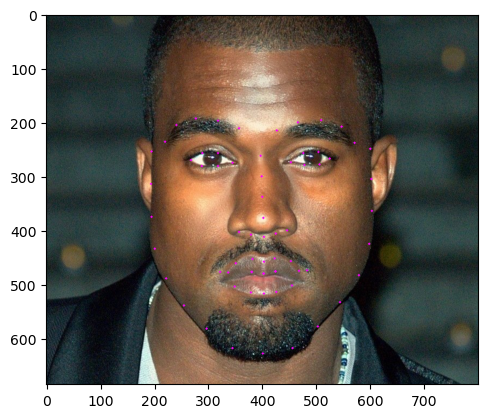

In [8]:
kanyeCoords = drawCoords(kanye_image)
plt.imshow(kanyeCoords)

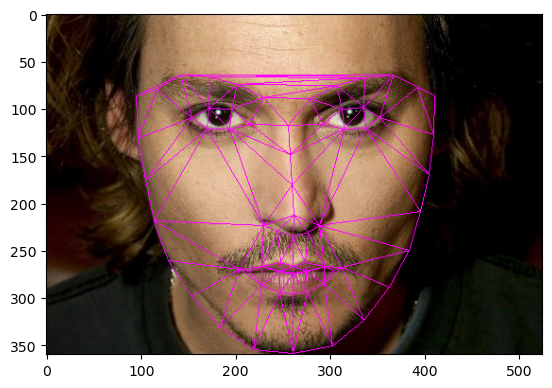

In [7]:
x = drawLines(depp_image)
plt.imshow(x)

In [8]:
# cap = cv2.VideoCapture(0)
 
# while True:
#     _, image = cap.read()
#     _, dest_coords = h.getTrianglesCoords(image, trianglesIndices=indices)
#     if type(dest_coords) != type(None):
#         x = h.swapAll(babka, image, src_coords, dest_coords)
#     else:
#         x = image

#     cv2.imshow("Output1", x)    
    
#     #close on Esc
#     k = cv2.waitKey(5) & 0xFF
#     if k == 27:
#         break

# cv2.destroyAllWindows()
# cap.release()

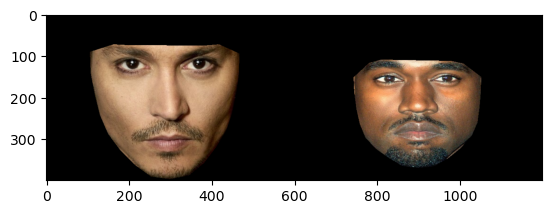

In [9]:
img1 = put_face_on_image(depp, np.zeros((400, 600, 3), dtype=np.uint8))
img2 = put_face_on_image(kanye, np.zeros((400, 600, 3), dtype=np.uint8))

img = np.concatenate([img1, img2], axis=1)
plt.imshow(img)

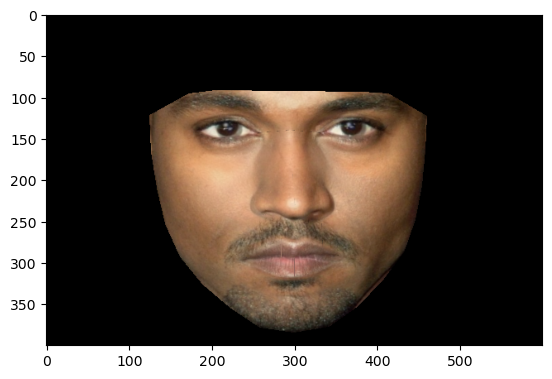

In [18]:
new_face = combine_faces(faces=[depp,kanye], weights=[1,1])
img = put_face_on_image(new_face, np.zeros((400, 600, 3), dtype=np.uint8))
plt.imshow(img)

In [11]:
face_morphing(faces=[kanye,depp], path='produced_gifs/depp&kanye.gif')